# Final Combination of Colour and numbers detection and recognition

### This section combines both the colour and shape/number recognition 
 

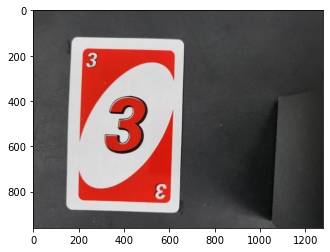

In [30]:
import cv2 as cv
import matplotlib.pyplot as plt

frame = cv.imread("CARDS/THREE_R.jpeg") # Here you can pick any CARD (from the dataset) you want to recognise
                                          #  ex: ("CARDS/"*" ") Replace the "*" with the image name + '.jpeg'
                                          # Example names:
                                          #  * ZERO_B.jpeg
                                          #  * TWO_B_DRAW.jpeg
                                          #  * SKIP_Y.jpeg
plt.imshow(frame[:,:,::-1])
plt.show()

In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

### Load dataset

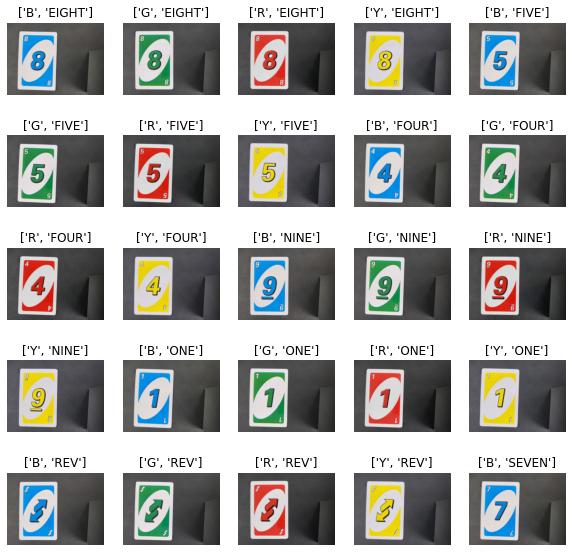

In [32]:
# Load dataset
images = []
labels = []

# Iterate through image files in dataset
fns = glob.glob("CARDS/*")
for fn in fns:
  # Load image
  img = cv.imread(fn)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(fn) # only get filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension

  
 
  # The second part is the colours (R,G,B,Y)
  # rest is number (or special)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### find_cards

This function will given a image, return a list
of images which are each card detected cropped
from the image.
                                                     
It first applies an adaptive threshold which is
really effective for variable lighting situations,
a simple threshold can do badly with non-optimal
lighting.
                                                     
Next all EXTERNAL contours are detected on the image
which should each represent a card. Some noise
could be picked up so a minimum area is required.
                                                     
Finally the card contours is approximated with an
oriented bounding box. There are some adjustements
on the contour, which is then wrapped/cropped into
a separate image using wrapPersective

In [33]:
MIN_AREA_CARD = 0.1*0.1

def find_cards(img):
  # Do adaptive threshold to find edges
  # Apply a gaussian blur just before to 
  # make sure it doesn't pick up noisy edges
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 



  # After finding the contours, the (two contours).
  # pick the most inner one.
  # Do dilatation. 
  
 


  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=8)

  # Find contour in thresholded image
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  # Card contours must have
  # 1. Have an certain minimal area
  # 2. Be the direct child of an external contour

  #  ┌────────────┐
  #  │┌──────────┐│ <-- external contour
  #  ││          ││
  #  ││          │<-- card contour
  #  ││          ││
  #  ││          ││
  #  ││          ││
  #  │└──────────┘│
  #  └────────────┘
  #
  card_contours = []

  for i, cnt in enumerate(contours):
    # Check that contour is external
    if hierarchy[0][i][3] == -1:
      # # Check that contour has child
      if hierarchy[0][i][2] != -1:
        # Check that contour has minimal area
        if cv.contourArea(contours[hierarchy[0][i][2]]) > np.size(th) * MIN_AREA_CARD:
          card_contours.append(hierarchy[0][i][2])


  card_imgs = []
  card_outlines = []

  for idx in card_contours:
    cnt = contours[idx]
    # Find oriented bounding box around card
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)

    # Have the most top-left first, and also 
    # the contour should be clockwise from the 
    # previous functions
    idx_leftop = np.argmin([p[0]+p[1] for p in box])
    box_ordered = []
    for j in range(4):
      box_ordered.append(box[(idx_leftop+j)%4])
    box = np.array(box_ordered)

    # Estimate card width and height

    #   [0]   l11   [1]
    #     ┌────────┐
    #     │        │
    # l22 │        │ l21
    #     │        │
    #     │        │
    #     └────────┘
    #   [3]   l12   [2]

    box_l11 = np.linalg.norm(box[0]-box[1])
    box_l12 = np.linalg.norm(box[2]-box[3])

    box_l21 = np.linalg.norm(box[1]-box[2])
    box_l22 = np.linalg.norm(box[3]-box[0])

    box_l1 = (box_l11+box_l12)/2
    box_l2 = (box_l21+box_l22)/2

    # Card is straight
    new_width, new_height = None, None
    if box_l1 < box_l2:
      new_points = np.array([
        [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
      new_width = box_l1
      new_height = box_l2

    # Card is on its side
    else:
      new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
      new_width = box_l2
      new_height = box_l1

    # Compute perspective transform matrix and get wrapped
    # image which is only the card
    M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
    roi = cv.warpPerspective(img, M, (round(new_width), round(new_height)))

    card_imgs.append(roi)
    card_outlines.append(box)

  return card_imgs, card_outlines

### find_dominant_color

Given an image finds the UNO color
1. The image is first resized with NEAREST
2. Do a K-means (K=2), should be white and UNO color
3. Pick color which is farthest from white

In [34]:
def find_dominant_color(img):
  # Resize image to have a width of 10
  # Here it's important that we resize using
  # "nearest". This assure that the color
  # are not mixed together during downsizing.
  fxy = 10/img.shape[1]
  small = cv.resize(img, None, fx=fxy, fy=fxy, interpolation=cv.INTER_NEAREST)

  # Apply k-means with k = 2
  # The expected outcome is to have white
  # and the card color
  Z = small.reshape((-1,3))
  Z = np.float32(Z)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

  # Pick the colour which is the farthest from pure white
  # this should be the card color
  idx_dominant = np.argmax([np.linalg.norm(c - np.array([255, 255, 255])) for c in center])
  dominant_color = center[idx_dominant]
  dominant_color = np.uint8(dominant_color)

  # Convert to HSV and extract hue
  dominant_color = cv.cvtColor(dominant_color[np.newaxis, np.newaxis, :], cv.COLOR_BGR2HSV)
  dominant_color = dominant_color[:,:,0]


  return dominant_color

# Given an image find the contour of the number
# at the center
def find_number_contour(img):
  # Do adaptive threshold to find the contours
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  # Some colors might not get clearly defined
  # during adaptive threshold. To fill any holes,
  # we do a morphological dilation
  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel)

  # Only find the external contour, the number in the
  # center should be an external contour
  contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  #Find contour closest to center
  center = np.array([th.shape[1]/2, th.shape[0]/2])
  contour_centers = []
  for cnt in contours:
    M = cv.moments(cnt)
    if M['m00'] != 0 and cv.contourArea(cnt) > 20:
      cx = int(M['m10']/M['m00'])
      cy = int(M['m01']/M['m00'])
      contour_centers.append(np.array([cx, cy]))
    else:
      contour_centers.append(np.array([0, 0]))

  if len(contour_centers) == 0:
    return None

  closest_idx = np.argmin([np.linalg.norm(c - center) for c in contour_centers])
  cnt = contours[closest_idx]

  # cnt is the number coutour


  return cnt

### find_number_contour

Given an image find the contour of the number
at the center

In [35]:
def find_number_contour(img):
  # Do adaptive threshold to find the contours
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  # Some colors might not get clearly defined
  # during adaptive threshold. To fill any holes,
  # we do a morphological dilation
  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel)

  # Only find the external contour, the number in the
  # center should be an external contour
  contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  #Find contour closest to center
  center = np.array([th.shape[1]/2, th.shape[0]/2])
  contour_centers = []
  for cnt in contours:
    M = cv.moments(cnt)
    if M['m00'] != 0 and cv.contourArea(cnt) > 20:
      cx = int(M['m10']/M['m00'])
      cy = int(M['m01']/M['m00'])
      contour_centers.append(np.array([cx, cy]))
    else:
      contour_centers.append(np.array([0, 0]))

  if len(contour_centers) == 0:
    return None

  closest_idx = np.argmin([np.linalg.norm(c - center) for c in contour_centers])
  cnt = contours[closest_idx]

  # cnt is the number coutour


  return cnt

### Find card for each image

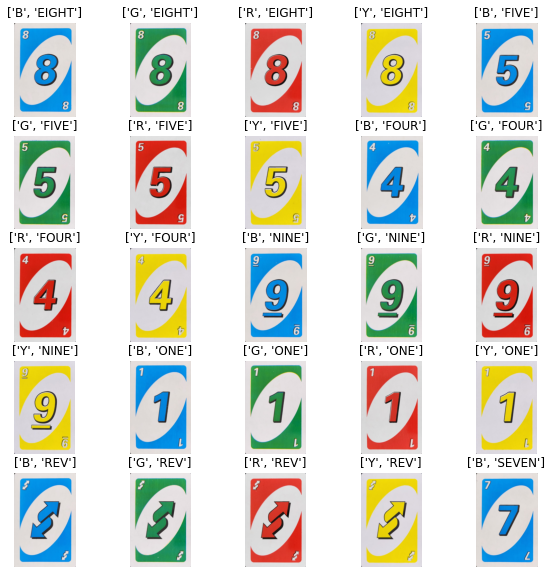

In [36]:


# For each train image, find the card inside it
# and only keep the card image
for i in range(len(images)):
  card_imgs, _ = find_cards(images[i])
  if len(card_imgs) != 1:
    # Multiple or zero cards detected in train data image
    print(f"Incorrect number of cards detected in {fns[i]}!")
  else:
    # Found one image, save it
    images[i] = card_imgs[0]

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### Normalize image sizes

In [37]:
CARD_WIDTH = 400
CARD_RATIO = 1.5
CARD_HEIGHT = 600

for i in range(len(images)):
  images[i] = cv.resize(images[i], (CARD_WIDTH, CARD_HEIGHT), interpolation=cv.INTER_AREA)

### Train for color

In [38]:
# Find dominant color each card
dominant_colors = []

for i in range(len(images)):
  dominant_color = find_dominant_color(images[i])
  dominant_colors.append(dominant_color)

### Train for number

In [39]:
train_contours = []

# Find the contour of the number in the center
# for each card and save it.
for i in range(len(images)):
  cnt = find_number_contour(images[i])
  train_contours.append(cnt)

### Test with data

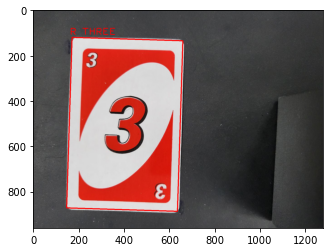

In [40]:
# Find cards 
card_imgs, card_outlines = find_cards(frame)
if len(card_outlines) > 0:
  cv.drawContours(frame, np.int0(card_outlines), -1, (0, 0, 255), 4)

if len(card_imgs) > 0:
  # Normalize size for card from webcam feed
  for i in range(len(card_imgs)):
    card_imgs[i] = cv.resize(card_imgs[i], (CARD_WIDTH, CARD_HEIGHT), interpolation=cv.INTER_AREA)

  colors = []
  numbers = []

  # For each card, determine color and number
  for i in range(len(card_imgs)):
    # Determine image color
    dominant_color = find_dominant_color(card_imgs[i])

    # Pick closest in train data
    closest_idx = np.argmin([
      np.min([abs(dominant_color - c), abs((dominant_color+255) - c), abs(dominant_color - (c+255))])
      for c in dominant_colors])


    # Determine image number contour
    cnt = find_number_contour(card_imgs[i])

    # If no center contour, output unknown
    if cnt is None:
      predict_num = "UNKNOWN"
    else:
      # Pick closest match in contour
      match_idx = np.argmin([cv.matchShapes(cnt,c,1,0.0) for c in train_contours])
      predict_num = labels[match_idx][1]

    colors.append(labels[closest_idx][0])
    numbers.append(predict_num)

  for i in range(len(card_imgs)):
    x, y = np.int0(card_outlines[i][0])
    cv.putText(frame, colors[i] + " " + numbers[i], (x-10, y-10), cv.FONT_HERSHEY_PLAIN, 3.0, (0, 0, 255), thickness = 2, lineType=cv.LINE_AA)


plt.imshow(frame[:,:,::-1])
plt.show()